# Ensemble Climate Model EVA


This is a script to perform statistical climate change analysis on a single-model multi-member ensemble,
focussed on extreme events at a particular location.

Since the climate is not stationary, a climate model large ensemble is used to pull enough years from
a short date range. 

The code calculates and plots the following three items:

1. Map showing change in variable mean and where the changes are significant
2. Changes in extreme events at a given return period, with estimated uncertainty
3. Changes in monthly mean distributions

The script uses xarray and CMIP6 data stored in the google cloud, so no need to have data pre-downloaded. 
Only the data needed is loaded, which avoids having to download *full* GCM ensemble dataset. H

Total runtime is dependent on number of ensemble members available/specified



In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import cartopy.crs as ccrs
from scipy.signal import find_peaks
import scipy.stats as stats
import warnings
import xesmf as xe
import cftime
from datetime import datetime
xr.set_options(display_style='html')
plt.rcParams['figure.figsize'] = 12, 6

### Define parameters

In [2]:

# set parameters for the analysis
n_ens_members=10         # number of model ensemble members 
sig_level=1.0           # significant level for statistical analysis, this number is multiplied with the standard deviation

# load CMIP5 databases for google cloud
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')


# set model queries
# guide for names here: https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q 
# firstly set queries for both ensemble
# the format of single and double quotation marks is important, so make sure these are kept 
variable = "'tasmax'"  
resolution = "'Amon'"
variant="'r1i1p1f1'"

# years to be tested
year_1=2000
year_2=2050


# then, set the historical ensemble details
activity_1="'CMIP'"
scenario_1 = "'historical'"
date_1_start ="1951-01-01"
date_1_end = "2014-12-25"

# lastly, set the future ensemble details
activity_2="'ScenarioMIP'"
scenario_2 = "'ssp585'"
date_2_start ="2015-01-01"
date_2_end = "2100-12-25"

# time resolution of requested data, in days
ts_res_days=1 

# set coordinates for location to be analyzed
# use Los Angeles as example
xc=360.0-118.2
yc=34.05

# data array for regridding
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90.0, 90.0, 1.0)),
                     'lon': (['lon'], np.arange(0.0, 360.0, 1.0)),
                    }
                   )

# set up regridder
#regridder = xe.Regridder(ds, ds_out, 'bilinear')

### End define parameters

The next block builds the query. This is where the actual dataset is prescribed, since the rest of the code will loop through the dataframes df_hist and df_fut.

In [3]:
# data base queries
# historical ensemble query
df_hist = df.query("activity_id== " + activity_1 + " & member_id == "+variant+" & table_id == "+resolution+" & variable_id == "+variable+" & experiment_id == "+scenario_1)

# future ensemble query
df_ssp = df.query("activity_id== " + activity_2 + " & member_id == "+variant+"  & table_id == "+resolution+" & variable_id == "+variable+" & experiment_id == "+scenario_2)


models = list(set(df_ssp['source_id']).intersection(df_hist['source_id']))
df_ssp.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
227255,ScenarioMIP,BCC,BCC-CSM2-MR,ssp585,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/ScenarioMIP/BCC/BCC-CSM2-MR/ssp585/...,NaN,20190314
228091,ScenarioMIP,CAS,FGOALS-g3,ssp585,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/ScenarioMIP/CAS/FGOALS-g3/ssp585/r1...,NaN,20190818
245806,ScenarioMIP,CCCma,CanESM5,ssp585,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN,20190429
254958,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp585,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2...,NaN,20191108
255715,ScenarioMIP,CSIRO,ACCESS-ESM1-5,ssp585,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp...,NaN,20191115


Next, we define the functions that are used during the actual analysis section of the code later on.

In [16]:
## DEFINE FUNCTIONS FOR LATER USE


def standardize_dims(ds):
    # function to standardize dimension names in cmip models
    # dimension names get mapped to the keys in the rdic dictionary
    # ds = input array
    # code adapted from Julius Buseckes' CMIP6 pre-processing package
    rdic = {
        "lon": ["x", "i", "nlon", "lon", "longitude"],
        "lat": ["y", "j", "nlat", "lat", "latitude"],
        "lev": ["lev", "depth", "olevel", "zlev", "olev"],
        "time": ["time","t"],
        }
    for di in rdic.keys():
        if di not in ds.coords:
            for wrong in rdic[di]:
                if wrong in ds.coords:
                    ds=ds.rename({wrong: di})
    return ds



    
def ecdf(sample):
    # function to calculate empirical cumulative distribution function
    # make numpy array
    # this code is adapted from stackoverflow
    sample = np.atleast_1d(sample)

    # produce quantiles and probabilities
    quantiles, counts = np.unique(sample, return_counts=True)

    # sum togther for cumulative distribution function
    cumprob = np.cumsum(counts).astype(np.double) / sample.size

    return quantiles, cumprob        
        
    


def plot_significant_changes(arr_diff,sig_level, n_ens_members):
    xr.set_options(display_style='html')
    plt.rcParams['figure.figsize'] = 18, 9
    # function to take two ensembles, plot the mean difference and show where the means are statistically different
    # arr_past = past ensemble
    # arr_future = future ensemble
    # sig_level = significance level, to be multiplied by the sample standard deviation
    # n_ens_members = number of ensemble members in input
    ts_m=arr_diff.mean(dim='member') # ensemble mean difference 
    ts_std=sig_level*arr_diff.std(dim='member')/(n_ens_members**(1/2)) # standard deviation 
    sig_map= ts_m.where(abs(ts_m)<ts_std); # calculate map for significance test
    # set up map, centred around the location of interest
    ax = plt.axes(projection=ccrs.Orthographic(xc, yc))
    ax.coastlines() # add coastlines
    # plot data
    ts_m.plot(subplot_kws=dict(projection=ccrs.Orthographic(xc-90, xc+90)),transform=ccrs.PlateCarree())
    
    # an error is generated when the entire map is significant, which is caught here
    # hashing is shown where the difference in the means is not significant
    try:
        p = sig_map.plot.contourf(subplot_kws=dict(projection=ccrs.Orthographic(xc-90, xc+90)),transform=ccrs.PlateCarree(),hatches=['///'],alpha=0)
        p.colorbar.remove()
    except:
        print('Significant everywhere')
        
    # plot location
    ax.plot(xc,yc,'m*', markersize=12)
    ax.set_global()
    fig = plt.gcf()
    fig.savefig('anomaly_map.png', dpi=200)
    return ts_m, ts_std

    
def is_significant(test1,test2,sig_level,n_ens_members):
    # function to test significance of two input arrays
    if abs(np.mean(test1)  - np.mean(test2)) > sig_level*((np.std(test1)**2 + np.std(test2)**2)/n_ens_members   )**(1/2) :
        return True
    else: 
        return False
    
    
    
def plot_timeseries(arr,sig_level,models):
    xr.set_options(display_style='html')
    plt.rcParams['figure.figsize'] = 18, 9
    data=arr.rolling(time=12, center=True).mean().interpolate_na(dim='time')-ens_ts.sel(time=slice("1951-01-16","1971-01-16")).mean(dim='time')
    lines=data.plot.line(alpha=0.15,x="time")
    data.mean(dim='member').plot.line('k-',linewidth=3,x="time")
    #data.quantile([0.05,0.95],dim='member').plot.line('r:',x="time")
    t1=data.sel(time=slice(str(year_1-3)+"-01-16",str(year_1+3)+"-12-16")).mean(dim="time")
    t2=data.sel(time=slice(str(year_2-3)+"-01-16",str(year_2+3)+"-12-16")).mean(dim="time")
    t1x = datetime.strptime(str(year_1)+"-01-16", '%Y-%m-%d')
    t2x = datetime.strptime(str(year_2)+"-01-16", '%Y-%m-%d')
    plt.plot(t1x,t1.mean(),'ro', markersize=12)
    plt.errorbar(t1x,t1.mean(),yerr=sig_level*t1.std(),xerr=None,ecolor='r',elinewidth=4,barsabove=True)
    plt.plot(t2x,t2.mean(),'ro', markersize=12)
    plt.errorbar(t2x,t2.mean(),yerr=sig_level*t1.std(),xerr=None,ecolor='r',elinewidth=4,barsabove=True)
    plt.legend(lines,models)
    if is_significant(t1,t2,sig_level,len(models)):
        print('Significant change from '+str(t1.mean().values)+' to '+str(t2.mean().values))
    else:
        print('No significant change')
    
### END DEFINE FUNCTIONS

### Get data from the cloud

In [5]:
# initialize gcfs token
print('Setting up database queries')
gcs = gcsfs.GCSFileSystem(token='anon')

# check that there are enough ensemble members for the specified analysis, otherwise update the specified number
if len(models) < n_ens_members:
    n_ens_members=len(models)
    print('Ensemble members updated to '+str(n_ens_members))
else:
    models=models[:n_ens_members]
    

# these two loops pull the past and future ensemble data from the cloud
for i in range(n_ens_members):
    print('Processing member: '+models[i]+' ...')
    df_hist = df.query("activity_id== " + activity_1 + " & source_id == "+"'"+models[i]+"'"+" & member_id == "+variant+" & table_id == "+resolution+" & variable_id == "+variable+" & experiment_id == "+scenario_1)

    # future ensemble query
    df_ssp = df.query("activity_id== " + activity_2 + "  & source_id == "+"'"+models[i]+"'"+"  & member_id == "+variant+"  & table_id == "+resolution+" & variable_id == "+variable+" & experiment_id == "+scenario_2)

    zstore = df_hist.zstore.values[0]

    # create a mutable-mapping-style interface to the store 
    mapper = gcs.get_mapper(zstore)

    # open data and select time slice 
    ds = xr.open_zarr(mapper, consolidated=True)
    ens_hist=ds[variable[1:-1]].sel(time=slice(date_1_start,date_1_end))


    zstore = df_ssp.zstore.values[0]

    # create a mutable-mapping-style interface to the store 
    mapper = gcs.get_mapper(zstore)

    # open data and select time slice 
    ds = xr.open_zarr(mapper, consolidated=True)
    ens_fut=ds[variable[1:-1]].sel(time=slice(date_2_start,date_2_end))


    # rename dimensions to standard names
    ens_hist=standardize_dims(ens_hist)
    ens_fut=standardize_dims(ens_fut)
    ens=xr.merge([ens_hist,ens_fut], compat="no_conflicts").to_array()
    #time = pd.date_range("1951-01-01", freq="M", periods=1752)
    #ens=ens.reindex({"time": time})
    
    # get timeseries
    ts=ens.sel(lon=xc,lat=yc, method="nearest").squeeze()
    try:
        datetimeindex = ts.indexes['time'].to_datetimeindex()
    except:
        datetimeindex = ts.indexes['time']
    ts['time']=datetimeindex
    if i == 0:
        ens_ts=ts
    else:
        ens_ts=xr.concat([ens_ts,ts], 'member')
    
    # get mean difference
    m1=ens.sel(time=slice(str(year_1-3)+"-01-16",str(year_1+3)+"-12-16")).mean(dim="time") # take time mean of each ensemble member
    m2=ens.sel(time=slice(str(year_2-3)+"-01-16",str(year_2+3)+"-12-16")).mean(dim="time") # take time mean of each ensemble member
    mdiff=m2-m1
    mdiff=mdiff.squeeze()

    
    
    regridder = xe.Regridder(ens, ds_out, 'bilinear')
    dr_out = regridder(mdiff)

    if i == 0:
        ens_diff=dr_out
    else:
        ens_diff=xr.concat([ens_diff,dr_out], 'member')
    print('Finished processing member: '+models[i])
ens_ts=ens_ts.squeeze()

Setting up database queries
Processing member: ACCESS-CM2 ...
Overwrite existing file: bilinear_144x192_180x360.nc 
 You can set reuse_weights=True to save computing time.
Finished processing member: ACCESS-CM2
Processing member: IPSL-CM6A-LR ...
Overwrite existing file: bilinear_143x144_180x360.nc 
 You can set reuse_weights=True to save computing time.
Finished processing member: IPSL-CM6A-LR
Processing member: MIROC6 ...
Overwrite existing file: bilinear_128x256_180x360.nc 
 You can set reuse_weights=True to save computing time.
Finished processing member: MIROC6
Processing member: BCC-CSM2-MR ...


/Users/benbronselaer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


Overwrite existing file: bilinear_160x320_180x360.nc 
 You can set reuse_weights=True to save computing time.
Finished processing member: BCC-CSM2-MR
Processing member: CanESM5 ...


/Users/benbronselaer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


Overwrite existing file: bilinear_64x128_180x360.nc 
 You can set reuse_weights=True to save computing time.
Finished processing member: CanESM5
Processing member: MRI-ESM2-0 ...
Overwrite existing file: bilinear_160x320_180x360.nc 
 You can set reuse_weights=True to save computing time.
Finished processing member: MRI-ESM2-0
Processing member: FGOALS-g3 ...


/Users/benbronselaer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


Overwrite existing file: bilinear_80x180_180x360.nc 
 You can set reuse_weights=True to save computing time.
Finished processing member: FGOALS-g3
Processing member: GFDL-CM4 ...


/Users/benbronselaer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


Overwrite existing file: bilinear_180x288_180x360.nc 
 You can set reuse_weights=True to save computing time.
Finished processing member: GFDL-CM4
Processing member: ACCESS-ESM1-5 ...
Overwrite existing file: bilinear_145x192_180x360.nc 
 You can set reuse_weights=True to save computing time.
Finished processing member: ACCESS-ESM1-5
Processing member: EC-Earth3 ...
Overwrite existing file: bilinear_256x512_180x360.nc 
 You can set reuse_weights=True to save computing time.
Finished processing member: EC-Earth3


In [6]:
%time ens_diff.load()
%time ens_ts.load()

CPU times: user 21.7 s, sys: 9.98 s, total: 31.6 s
Wall time: 3min 43s
CPU times: user 31.5 s, sys: 12.9 s, total: 44.3 s
Wall time: 5min 36s


<xarray.DataArray 'stack-4e749a75f7daecd1f608647ae804db43' (member: 10, time: 1837)>
array([[285.27603, 285.97296, 288.23413, ..., 306.21188, 297.7626 ,
        292.8641 ],
       [283.27686, 282.6535 , 287.00372, ..., 301.48935, 296.6618 ,
        292.63345],
       [288.99323, 290.67856, 294.0316 , ..., 314.09946, 298.90576,
        292.9399 ],
       ...,
       [285.81537, 288.10464, 286.04077, ..., 303.0989 , 292.37772,
        288.48035],
       [288.93405, 287.88614, 292.27048, ..., 302.49   , 295.95343,
        293.28848],
       [289.66696, 288.49872, 289.4448 , ..., 304.061  , 299.3933 ,
        293.43588]], dtype=float32)
Coordinates:
    variable  <U6 'tasmax'
    height    float64 2.0
  * time      (time) datetime64[ns] 1951-01-16T12:00:00 ... 2100-12-16T12:00:00
    lat       (member) float64 34.38 34.23 34.32 34.21 ... 34.5 33.75 34.04
    lon       (member) float64 240.9 242.5 241.9 241.9 ... 241.9 241.9 241.5
Dimensions without coordinates: member

/Users/benbronselaer/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Significant change from 0.64120936 to 3.0747957


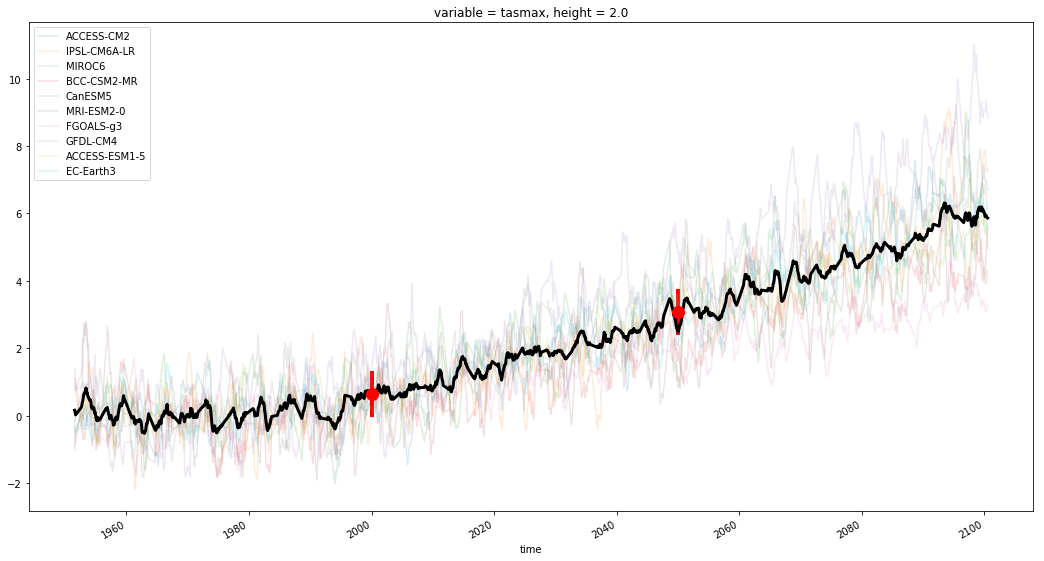

In [17]:
plot_timeseries(ens_ts,2,models)

In [8]:
data=ens_ts.rolling(time=12, center=True).mean().interpolate_na(dim='time')-ens_ts.sel(time=slice(date_1_start,date_1_end)).mean()

Significant everywhere


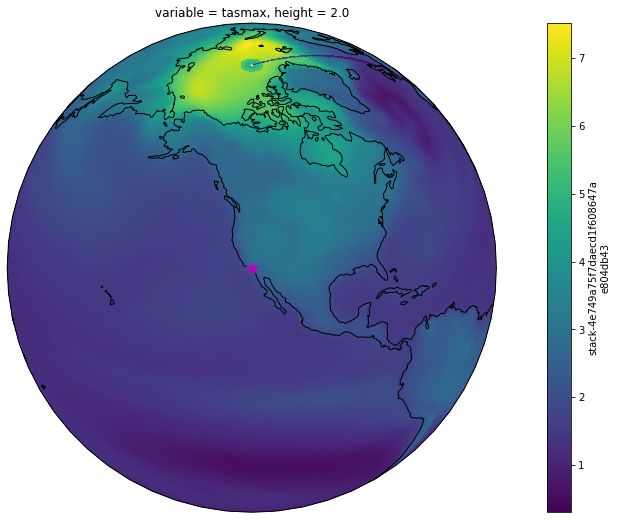

In [13]:
plot_significant_changes(ens_diff,sig_level, n_ens_members);